In [1]:
import os
import cv2
import numpy as np

# Función para cargar imágenes desde una ruta especificada
def cargar_imagenes(directorio, tamaño=(128, 128)):
    imagenes = []
    etiquetas = []
    for clase in os.listdir(directorio):
        ruta_clase = os.path.join(directorio, clase)
        if os.path.isdir(ruta_clase):
            for nombre_img in os.listdir(ruta_clase):
                ruta_img = os.path.join(ruta_clase, nombre_img)
                img = cv2.imread(ruta_img)
                if img is not None:
                    img = cv2.resize(img, tamaño)
                    imagenes.append(img)
                    etiquetas.append(clase)
    return np.array(imagenes), np.array(etiquetas)

In [2]:
# Ruta de las imágenes de hojas de mango
ruta_imagenes = '/content/drive/MyDrive/Semestre 9/Visión por Computador/Semana_10/mango_leaf_disease/mango_leaf_disease'  # Cambia esta ruta según sea necesario
imagenes, etiquetas = cargar_imagenes(ruta_imagenes)

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

# Directorio que contiene las carpetas de clases
directorio_base = '/content/drive/MyDrive/Semestre 9/Visión por Computador/Semana_10/mango_leaf_disease/mango_leaf_disease'

In [4]:
# Mostrar las subcarpetas
clases = [carpeta for carpeta in os.listdir(directorio_base) if os.path.isdir(os.path.join(directorio_base, carpeta))]
print(f'Clases encontradas: {clases}')

Clases encontradas: ['Sooty Mould', 'Powdery Mildew', 'Cutting Weevil', 'Bacterial Canker', 'Healthy', 'Gall Midge', 'Die Back', 'Anthracnose']


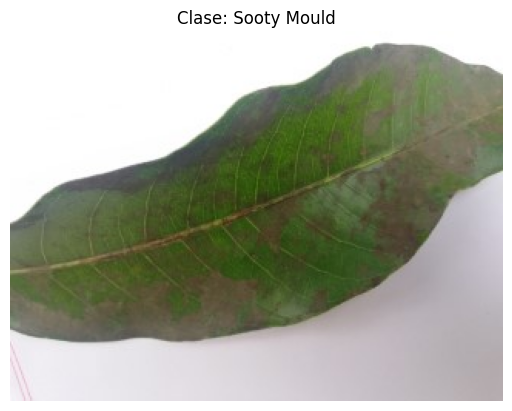

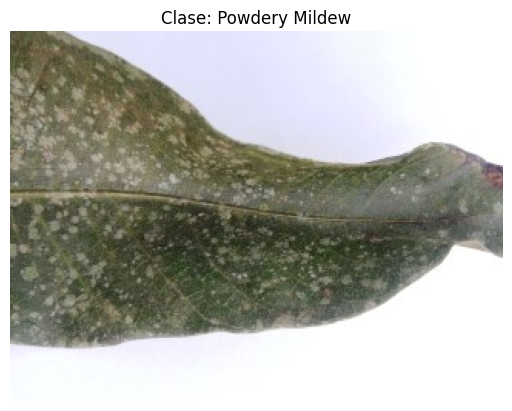

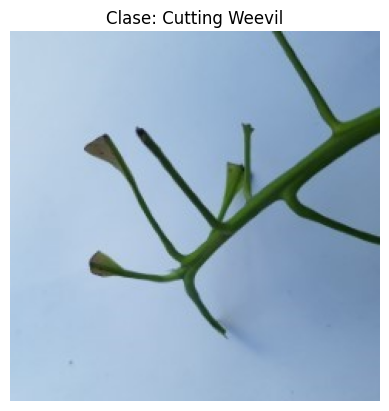

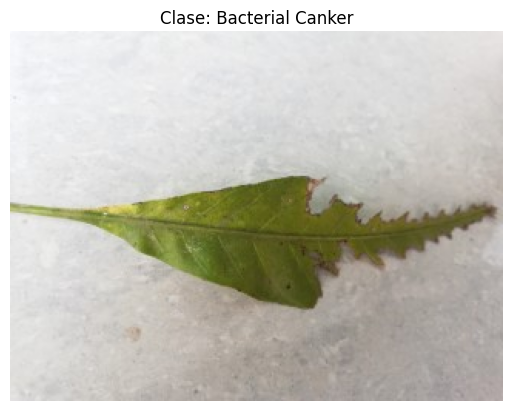

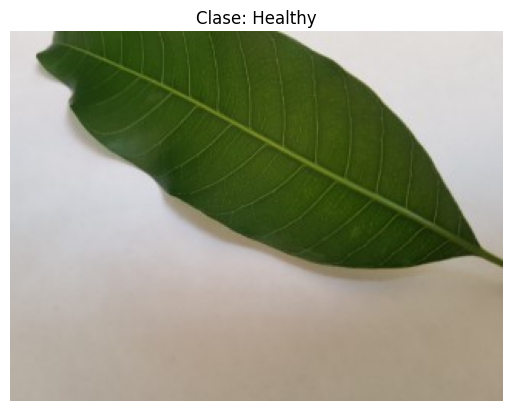

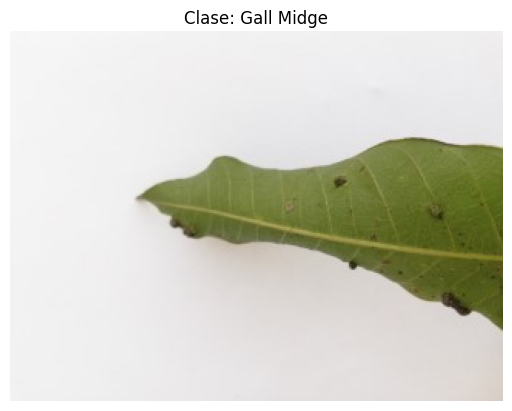

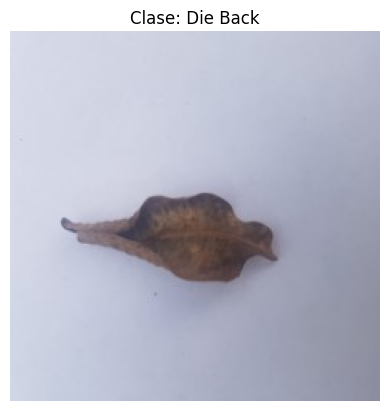

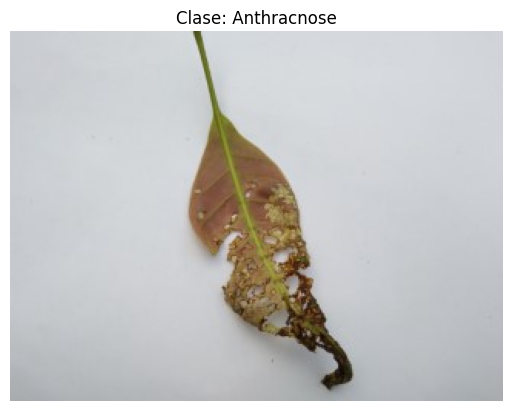

In [5]:
# Visualizar una imagen de cada clase
for clase in clases:
    ruta_clase = os.path.join(directorio_base, clase)
    lista_imagenes = [img for img in os.listdir(ruta_clase) if img.endswith(('png', 'jpg', 'jpeg'))]

    if lista_imagenes:
        ruta_img = os.path.join(ruta_clase, lista_imagenes[0])  # Seleccionar la primera imagen
        imagen = Image.open(ruta_img)

        # Mostrar imagen y etiqueta
        plt.imshow(imagen)
        plt.title(f'Clase: {clase}')
        plt.axis('off')
        plt.show()
    else:
        print(f'Sin imágenes en la clase: {clase}')

In [6]:
# Función para calcular momentos de color
def momentos_de_color(imagen):
    canales = cv2.split(imagen)
    momentos = []
    for canal in canales:
        media = np.mean(canal)
        desviacion = np.std(canal)
        asimetria = np.mean((canal - media) ** 3)
        momentos.extend([media, desviacion, asimetria])
    return momentos


In [7]:

# Función para obtener el descriptor de Fourier
def descriptor_fourier(imagen):
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    transformada = np.fft.fft2(gris)
    transformada_centrada = np.fft.fftshift(transformada)
    espectro_magnitud = np.log(np.abs(transformada_centrada) + 1)
    return espectro_magnitud.flatten()[:1000]


from sklearn.cluster import KMeans

In [8]:
# Función para extraer los colores dominantes
def color_dominante(imagen, clusters=3):
    pixeles = imagen.reshape(-1, 3)
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(pixeles)
    return kmeans.cluster_centers_.flatten()

In [9]:
# Función para extraer características de cada imagen
def extraer_caracteristicas(imagen):
    caracteristicas = []
    caracteristicas.extend(momentos_de_color(imagen))
    caracteristicas.extend(descriptor_fourier(imagen))
    caracteristicas.extend(color_dominante(imagen))
    return caracteristicas

In [10]:
from scipy.spatial.distance import euclidean

# Calcular la distancia euclidiana entre dos vectores de características
def distancia_euclidiana(vec1, vec2):
    return euclidean(vec1, vec2)


In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Preparar las características y etiquetas para el modelo
X = [extraer_caracteristicas(img) for img in imagenes]
y = etiquetas

In [12]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Entrenar el clasificador KNN
modelo_knn = KNeighborsClassifier(n_neighbors=5)
modelo_knn.fit(X_entrenamiento, y_entrenamiento)

KNeighborsClassifier()

In [14]:
# Realizar predicciones y calcular la precisión
y_predicciones = modelo_knn.predict(X_prueba)
print("Precisión:", accuracy_score(y_prueba, y_predicciones))

Precisión: 0.755


In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generar la matriz de confusión
matriz_confusion = confusion_matrix(y_prueba, y_predicciones)

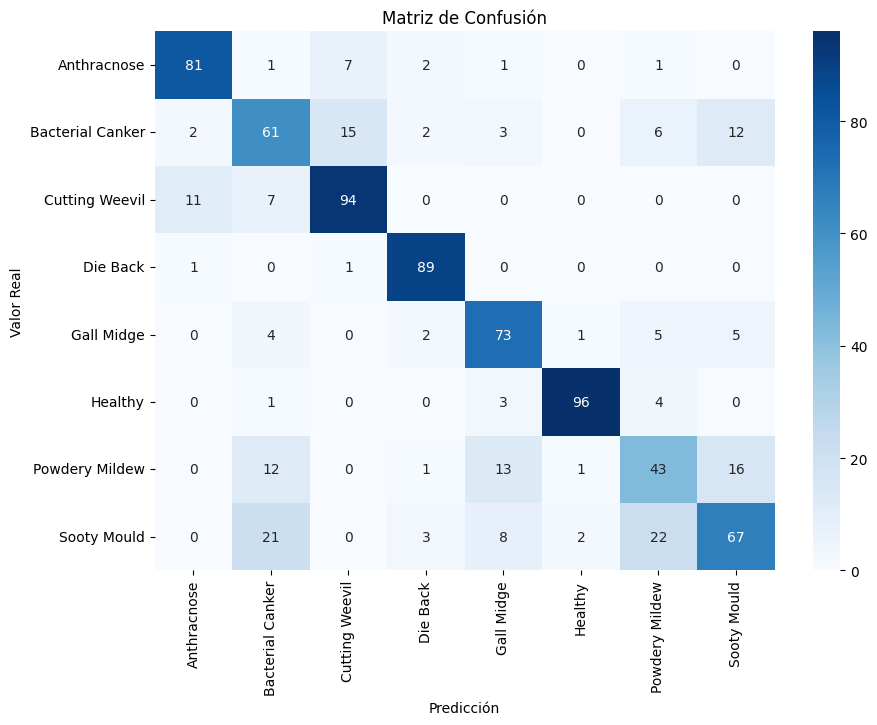

In [16]:
# Mostrar la matriz de confusión en un mapa de calor
plt.figure(figsize=(10, 7))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

In [17]:
import random

# Visualizar algunas predicciones aleatorias del conjunto de prueba
indices_aleatorios = random.sample(range(len(X_prueba)), 5)

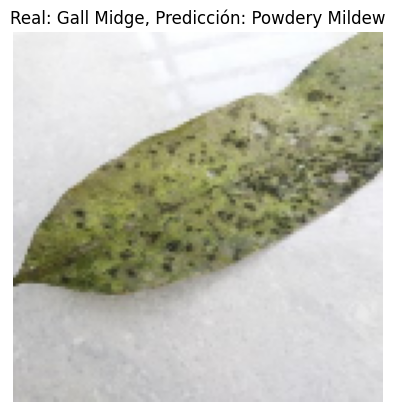

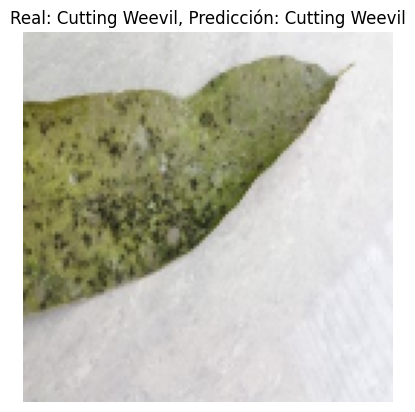

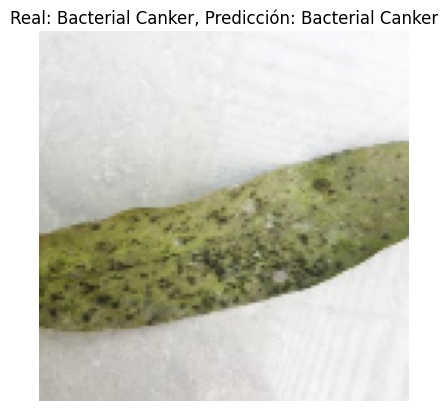

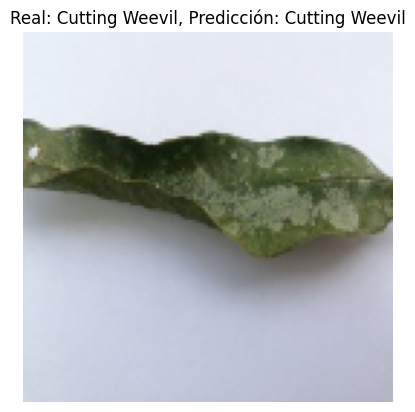

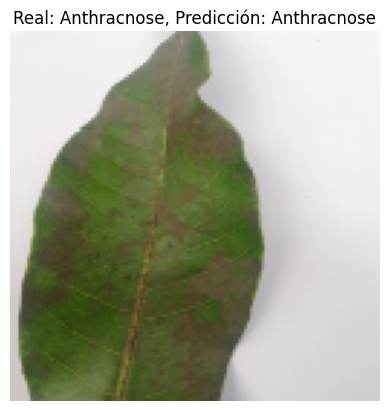

In [18]:
for idx in indices_aleatorios:
    img = imagenes[idx]  # Mostrar la imagen original
    etiqueta_real = y_prueba[idx]
    etiqueta_predicha = y_predicciones[idx]

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Real: {etiqueta_real}, Predicción: {etiqueta_predicha}')
    plt.axis('off')
    plt.show()